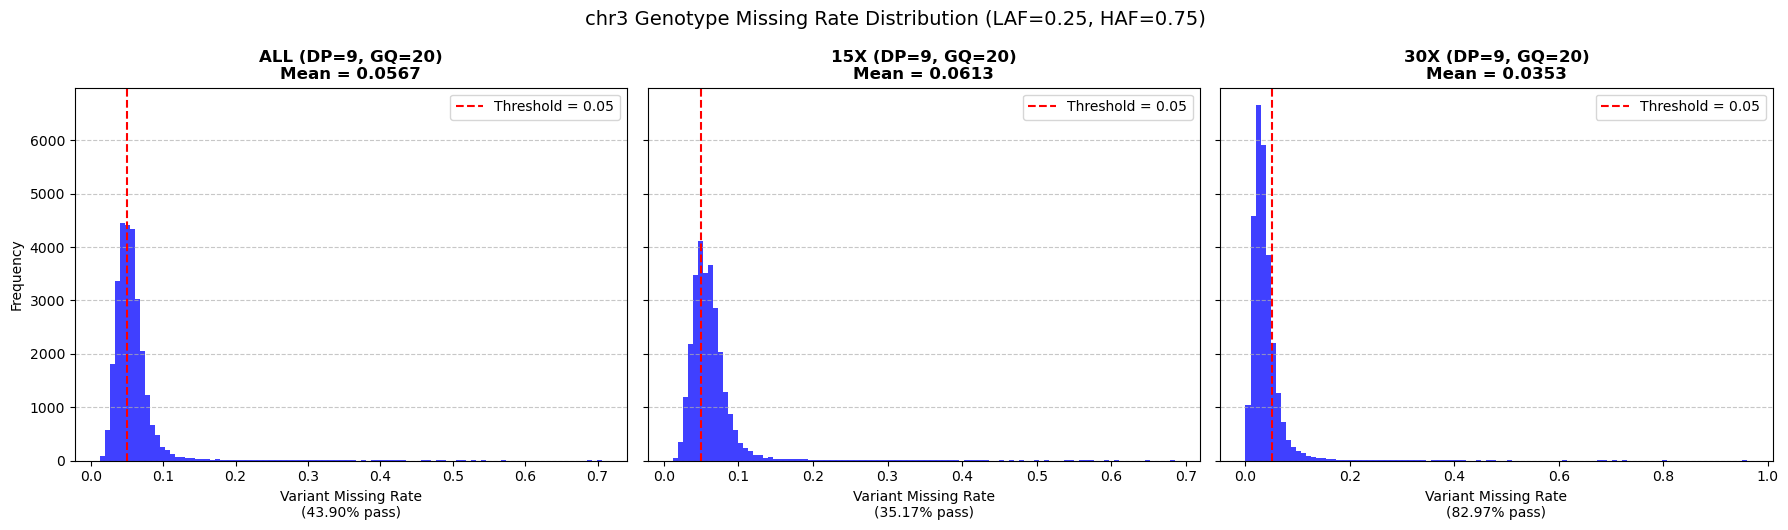

In [2]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# === 输入参数 ===
chr = "chr3"
DP = 9
GQ = 20
LAF = 0.25
HAF = 0.75
miss_threshold = 0.05

# === 路径与文件读取 ===
work_dir = f"/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/tuning.concordance.rev1/results/03.concordance_vmiss_summary/{chr}"
dict_file = os.path.join(work_dir, f"{chr}._DP{DP}_GQ{GQ}_LAF{LAF}_HAF{HAF}_.summary.pkl")

with open(dict_file, "rb") as f:
    data_dict = pickle.load(f)

# === 提取 vmss_df 并绘图 ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
platforms = ['ALL', '15X', '30X']

for i, platform in enumerate(platforms):
    key = frozenset([f'DP{DP}', f'GQ{GQ}', f'LAF{LAF}', f'HAF{HAF}', platform])
    if key not in data_dict:
        print(f"⚠️ Key not found for platform {platform}")
        continue

    vmiss_df = data_dict[key][0]
    missing_rates = vmiss_df["VMISS_FREQ"]
    mean_miss = missing_rates.mean()
    percent_pass = (missing_rates < miss_threshold).sum() / len(missing_rates) * 100

    ax = axes[i]
    ax.hist(missing_rates, bins=100, alpha=0.75, color='blue')
    ax.axvline(x=miss_threshold, color='red', linestyle='--', linewidth=1.5, label=f'Threshold = {miss_threshold}')
    ax.set_title(f'{platform} (DP={DP}, GQ={GQ})\nMean = {mean_miss:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel(f'Variant Missing Rate\n({percent_pass:.2f}% pass)', fontsize=10)
    if i == 0:
        ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()

plt.style.use('default')
plt.tight_layout()
plt.suptitle(f"{chr} Genotype Missing Rate Distribution (LAF={LAF}, HAF={HAF})", fontsize=14, y=1.05)
plt.show()

In [1]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import product
import os
import pickle
import pandas as pd

def load_single_summary(chr, dp, gq, laf, haf, work_dir):
    filename = f"{chr}._DP{dp}_GQ{gq}_LAF{laf}_HAF{haf}_.summary.pkl"
    filepath = os.path.join(work_dir, filename)

    summary_15x_list, summary_30x_list, summary_all_list = [], [], []

    if not os.path.exists(filepath):
        return summary_15x_list, summary_30x_list, summary_all_list

    try:
        with open(filepath, 'rb') as f:
            result_dict = pickle.load(f)

        key_base = [f'DP{dp}', f'GQ{gq}', f'LAF{laf}', f'HAF{haf}']
        for platform, summary_list in zip(['15X', '30X', 'ALL'],
                                          [summary_15x_list, summary_30x_list, summary_all_list]):
            key = frozenset(key_base + [platform])
            if key in result_dict:
                summary_df = result_dict[key][2].copy()
                summary_df["PLATFORM"] = platform
                summary_list.append(summary_df)
    except Exception as e:
        print(f"❌ Error in {filename}: {e}")

    return summary_15x_list, summary_30x_list, summary_all_list

def load_summary_tables_parallel(
    chr: str,
    dp_range: range,
    gq_values: list,
    laf_values: list,
    haf_values: list,
    work_dir_base: str,
    max_workers: int = 8
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    work_dir = os.path.join(work_dir_base, chr)
    param_combinations = list(product(dp_range, gq_values, laf_values, haf_values))

    summary_15x_all, summary_30x_all, summary_all_all = [], [], []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(load_single_summary, chr, dp, gq, laf, haf, work_dir): (dp, gq, laf, haf)
            for dp, gq, laf, haf in param_combinations
        }

        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading summaries"):
            s15x, s30x, sall = future.result()
            summary_15x_all.extend(s15x)
            summary_30x_all.extend(s30x)
            summary_all_all.extend(sall)

    return (
        pd.concat(summary_15x_all, ignore_index=True),
        pd.concat(summary_30x_all, ignore_index=True),
        pd.concat(summary_all_all, ignore_index=True)
    )

# 设置参数
chr = "chr3"
dp_range = range(1, 31)
gq_values = [10, 20, 30]
laf_values = [0.0, 0.1, 0.15, 0.2, 0.25, 0.3]
haf_values = [1.0, 0.9, 0.85, 0.8, 0.75, 0.7]
work_dir_base = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/tuning.concordance.rev1/results/03.concordance_vmiss_summary"

summary_15x, summary_30x, summary_all = load_summary_tables_parallel(
    chr=chr,
    dp_range=dp_range,
    gq_values=gq_values,
    laf_values=laf_values,
    haf_values=haf_values,
    work_dir_base=work_dir_base,
    max_workers=4  # ← 你机器的CPU核心数
)

Loading summaries: 100%|██████████| 3240/3240 [01:10<00:00, 46.17it/s]


In [3]:
# summary_15x.to_csv(f"{chr}_summary_15x.csv", index=False)
# summary_30x.to_csv(f"{chr}_summary_30x.csv", index=False)
# summary_all.to_csv(f"{chr}_summary_all.csv", index=False)
# print("✅ Summary tables saved as CSV files.")

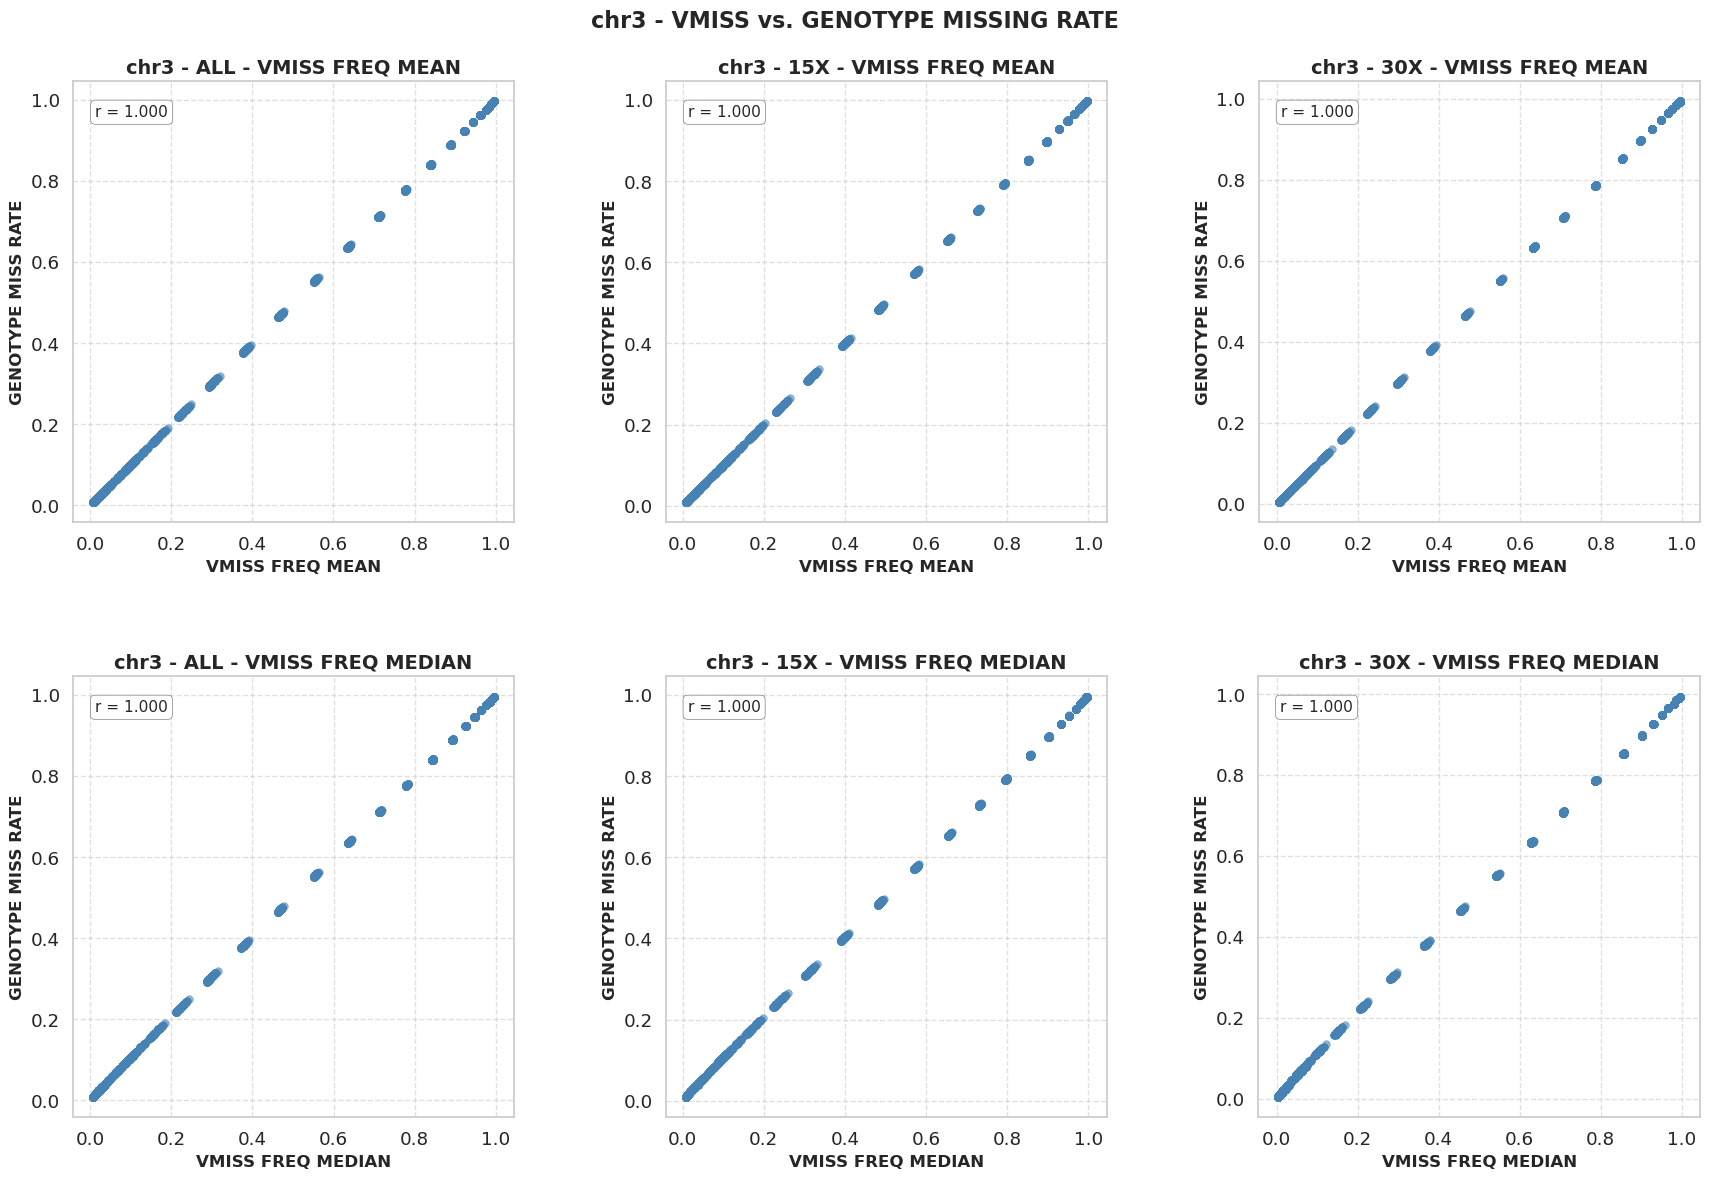

In [2]:
from tkinter import font
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def plot_vmiss_vs_genomissrate(summary_all, summary_15x, summary_30x, chr_label):
    """
    绘制两行三列正方形散点图：
    - 第一行：VMISS_FREQ_MEAN vs. GENOTYPE_MISS_RATE
    - 第二行：VMISS_FREQ_MEDIAN vs. GENOTYPE_MISS_RATE
    每个图中添加皮尔逊相关系数。
    """

    # 准备数据和标题
    datasets = [summary_all, summary_15x, summary_30x]
    titles = ['ALL', '15X', '30X']
    x_labels = ['VMISS_FREQ_MEAN', 'VMISS_FREQ_MEDIAN']
    
    sns.set_theme(style="whitegrid", font_scale=1.2)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=False, sharey=False)

    for col_idx, (df, platform_title) in enumerate(zip(datasets, titles)):
        for row_idx, x_var in enumerate(x_labels):
            ax = axes[row_idx][col_idx]

            # 相关系数
            x = df[x_var]
            y = df["GENOTYPE_MISS_RATE"]
            r, p = stats.pearsonr(x, y)
            corr_text = f"r = {r:.3f}"

            # 绘图
            sns.scatterplot(
                data=df,
                x=x_var,
                y='GENOTYPE_MISS_RATE',
                ax=ax,
                s=30,
                color="steelblue",
                alpha=0.6,
                edgecolor=None
            )

            ax.set_title(
                f"{chr_label} - {platform_title} - {x_var.replace('_', ' ')}",
                fontsize=14,
                fontweight='bold'
            )
            ax.set_xlabel(x_var.replace('_', ' '), fontsize=12, fontweight='bold')
            ax.set_ylabel("GENOTYPE MISS RATE", fontsize=12, fontweight='bold')

            # 正方形比例
            ax.set_aspect('equal', adjustable='box')

            # 标注相关性
            ax.text(
                0.05, 0.92, corr_text,
                transform=ax.transAxes,
                fontsize=11,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5)
            )

            ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    fig.subplots_adjust(top=0.92, hspace=0.35)
    fig.suptitle(f"{chr_label} - VMISS vs. GENOTYPE MISSING RATE", fontsize=16, fontweight='bold')
    plt.show()

# chr = "chr22"
plot_vmiss_vs_genomissrate(summary_all, summary_15x, summary_30x, chr_label=chr)

# 变体的缺失不是集中在某几个样本上发生的，而是样本之间比较“平均”地缺失

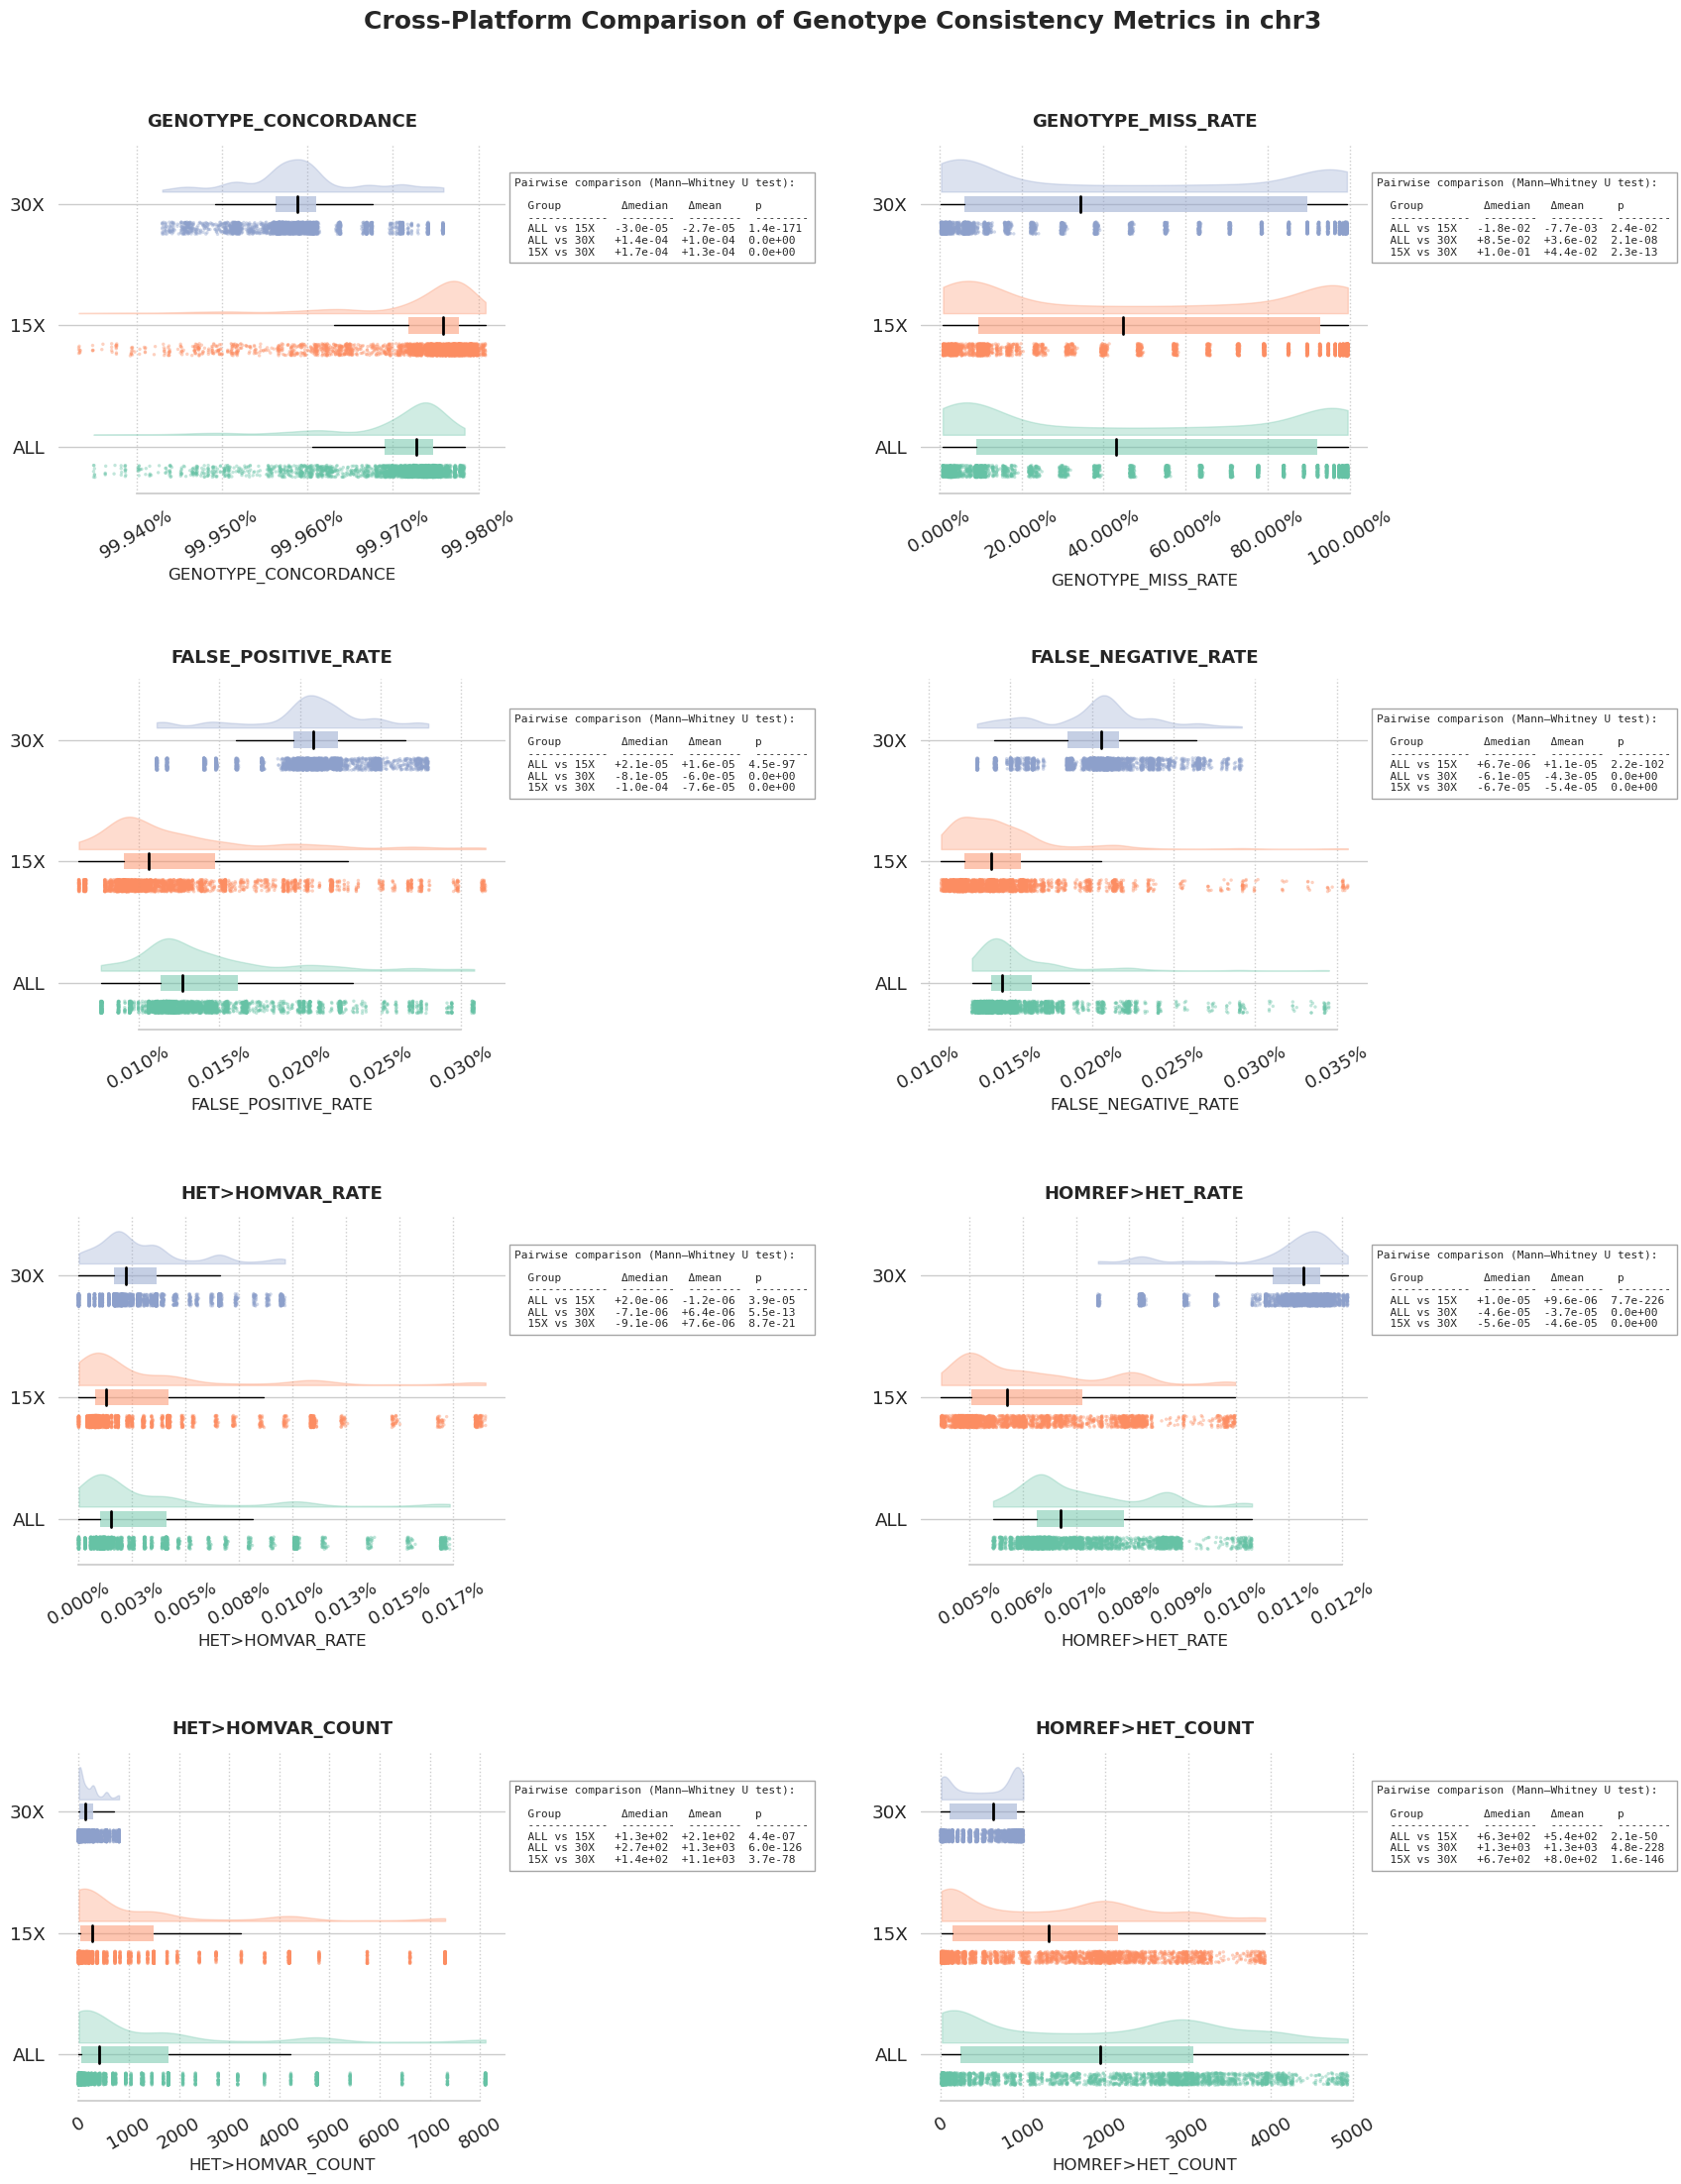

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, mannwhitneyu
import seaborn as sns
from itertools import combinations

def plot_raincloud_with_stats(summary_all, summary_15x, summary_30x, metric="GENOTYPE_CONCORDANCE", fig=None, ax=None):
    sns.set_theme(style="white", font_scale=1.2)

    platforms = ["ALL", "15X", "30X"]
    platform_color_map = {
        "ALL": "#66c2a5",
        "15X": "#fc8d62",
        "30X": "#8da0cb"
    }

    cols = ["DP", "GQ", "LAF", "HAF", metric]

    def prepare(df, platform):
        df = df[cols].copy()
        df["PLATFORM"] = platform
        return df

    df_all = prepare(summary_all, "ALL")
    df_15x = prepare(summary_15x, "15X")
    df_30x = prepare(summary_30x, "30X")
    df_plot = pd.concat([df_all, df_15x, df_30x], ignore_index=True)

    data_dict = {p: df_plot[df_plot["PLATFORM"] == p][metric].dropna().values for p in platforms}

    y_base = np.arange(len(platforms)) * 3
    violin_height = 0.8
    box_height = 0.4
    scatter_offset = -0.6

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        show_flag = True
    else:
        show_flag = False

    for i, platform in enumerate(platforms):
        x = data_dict[platform]
        y_center = y_base[i]
        base_color = platform_color_map[platform]

        kde = gaussian_kde(x, bw_method=0.2)
        x_grid = np.linspace(x.min(), x.max(), 300)
        kde_values = kde(x_grid)
        kde_values = kde_values / kde_values.max() * violin_height
        y_kde = y_center + 0.3
        ax.fill_between(x_grid, y_kde, y_kde + kde_values,
                        facecolor=base_color, alpha=0.3, edgecolor=base_color, linewidth=1)

        q1, q2, q3 = np.percentile(x, [25, 50, 75]) # type: ignore
        iqr = q3 - q1
        lw = np.min(x[x >= q1 - 1.5 * iqr])
        uw = np.max(x[x <= q3 + 1.5 * iqr])
        ax.add_patch(plt.Rectangle((q1, y_center - box_height / 2), q3 - q1, box_height,
                                   facecolor=base_color, edgecolor='none', alpha=0.5))
        ax.plot([q2, q2], [y_center - box_height / 2, y_center + box_height / 2], color='black', lw=2)
        ax.plot([lw, q1], [y_center, y_center], color='black', lw=1)
        ax.plot([q3, uw], [y_center, y_center], color='black', lw=1)

        jitter_y = y_center + scatter_offset + np.random.uniform(-0.15, 0.15, size=len(x))
        ax.scatter(x, jitter_y, s=6, alpha=0.4, color=base_color, edgecolor='none')

    # === 生成 pairwise 统计注释 ===
    text_lines = [
        "Pairwise comparison (Mann–Whitney U test):\n",
        "  Group         Δmedian   Δmean     p",
        "  ------------  --------  --------  --------"
    ]

    for g1, g2 in combinations(platforms, 2):
        x = data_dict[g1]
        y = data_dict[g2]
        median_diff = np.median(x) - np.median(y) # type: ignore
        mean_diff = np.mean(x) - np.mean(y) # type: ignore
        _, p = mannwhitneyu(x, y, alternative='two-sided')
        label = f"{g1} vs {g2}"
        row = f"  {label:<12} {median_diff:+.1e}  {mean_diff:+.1e}  {p:.1e}"
        text_lines.append(row)

    # === 在每个 subplot 中绑定注释（右上角 inset） ===
    inset = ax.inset_axes([1.02, 0.1, 0.45, 0.8], transform=ax.transAxes)  # 相对于 ax 的坐标
    inset.axis("off")
    inset.text(
        0, 1, "\n".join(text_lines),
        ha='left', va='top', fontsize=8, family='monospace',
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
    )

    # === 图美化 ===
    ax.set_yticks(y_base)
    ax.set_yticklabels(platforms)
    ax.ticklabel_format(useOffset=False, axis='x')
    ax.tick_params(axis='x', labelrotation=30)  # 旋转刻度避免重叠
    ax.set_xlabel(metric, fontsize=12)
    # 判断是否为浮点型（有小数点），有则用百分比格式，否则用整数
    if any(df_plot[metric].dtype == float for df_plot in [df_all, df_15x, df_30x]) or any("." in str(x) for x in df_plot[metric].astype(str)):
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x * 100:.3f}%")) # type: ignore
    else:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}")) # type: ignore
    ax.set_title(metric, fontsize=13, pad=12, fontweight='bold')
    ax.grid(axis='x', linestyle=':', alpha=1.0)
    sns.despine(ax=ax, trim=True, left=True)

    if show_flag:
        plt.tight_layout(rect=(0, 0, 0.92, 1))
        plt.show()
    
metrics = [
    "GENOTYPE_CONCORDANCE",
    "GENOTYPE_MISS_RATE",
    "FALSE_POSITIVE_RATE",
    "FALSE_NEGATIVE_RATE",
    "HET>HOMVAR_RATE",
    "HOMREF>HET_RATE",
    "HET>HOMVAR_COUNT", 
    "HOMREF>HET_COUNT",
]

fig, axes = plt.subplots(4, 2, figsize=(18, 22))  # 更宽一些用于注释空间
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    plot_raincloud_with_stats(summary_all, summary_15x, summary_30x, metric=metric, fig=fig, ax=ax)

plt.tight_layout(pad=3.0)
fig.suptitle(f"Cross-Platform Comparison of Genotype Consistency Metrics in {chr}", fontsize=18, fontweight='bold', y=1.02)
plt.show()

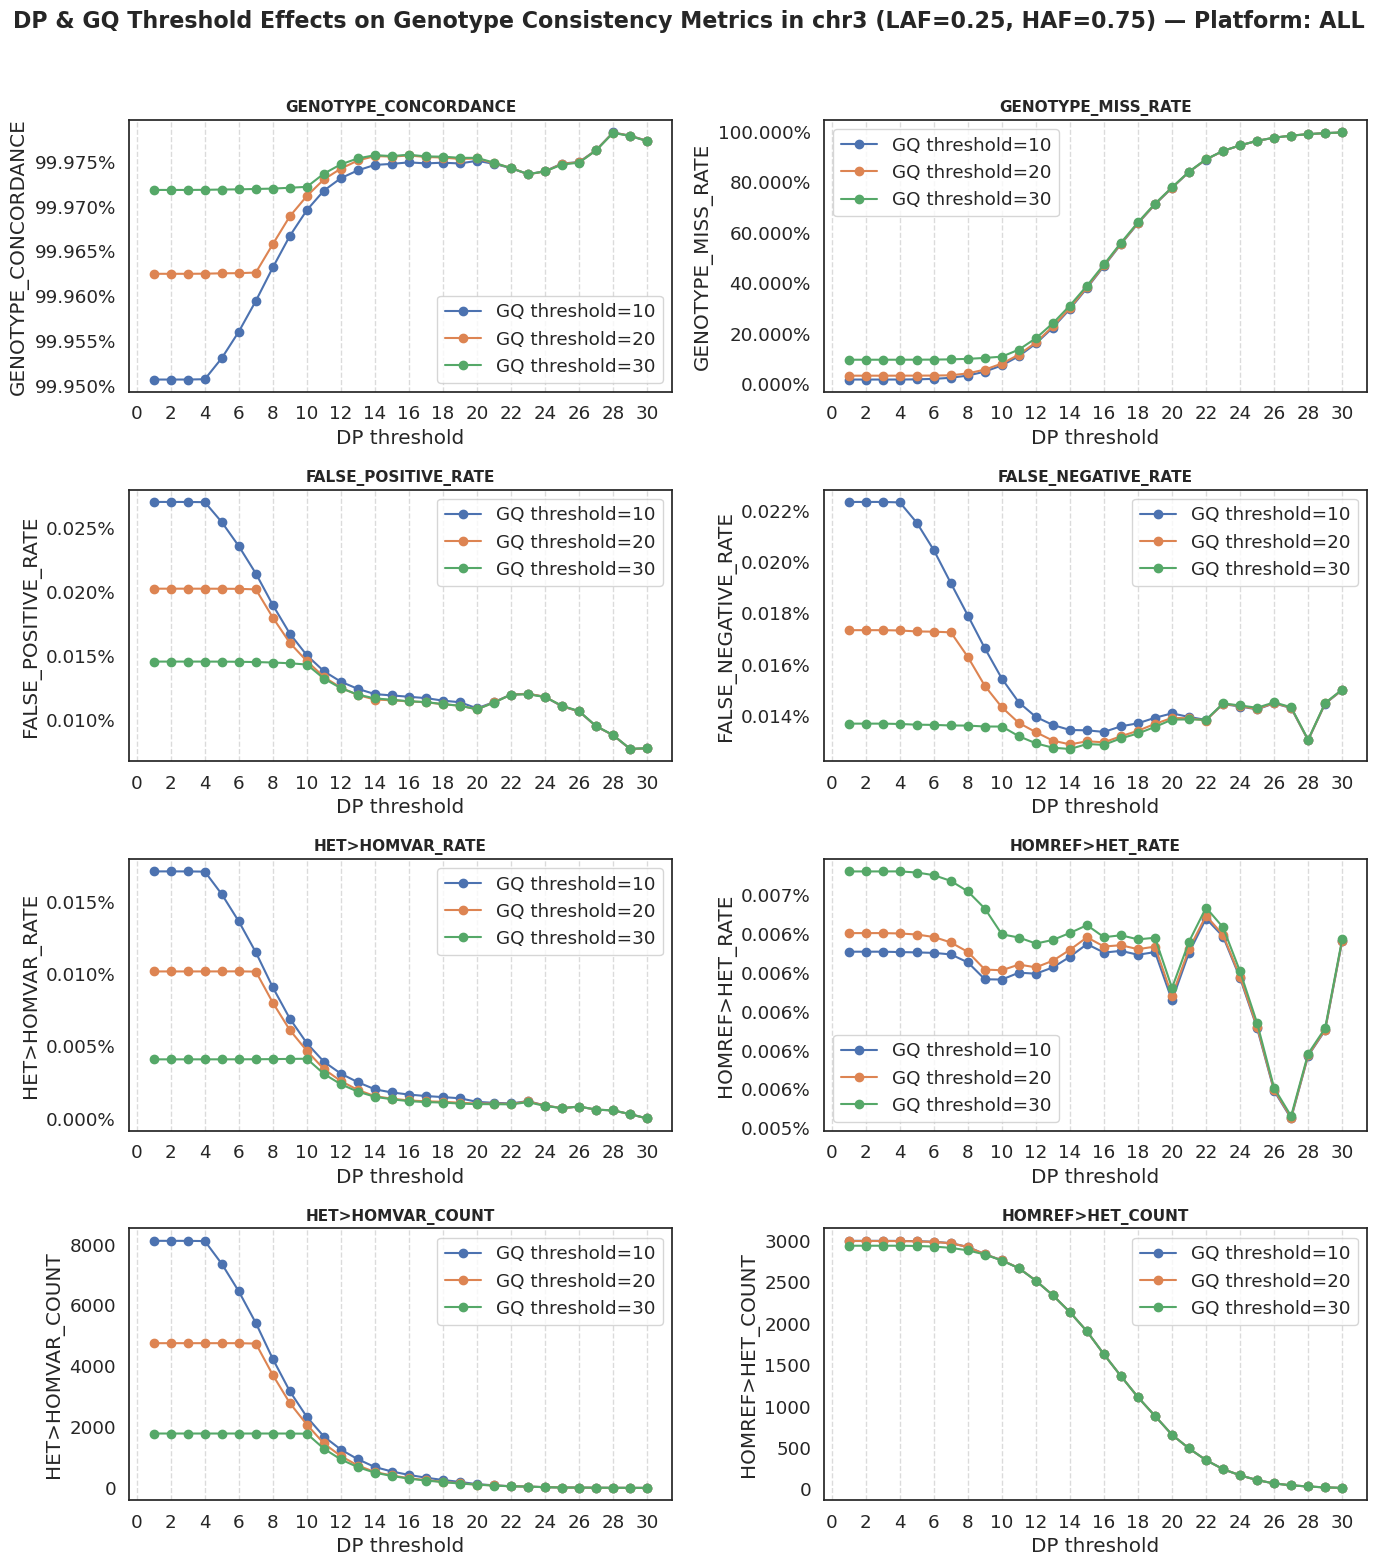

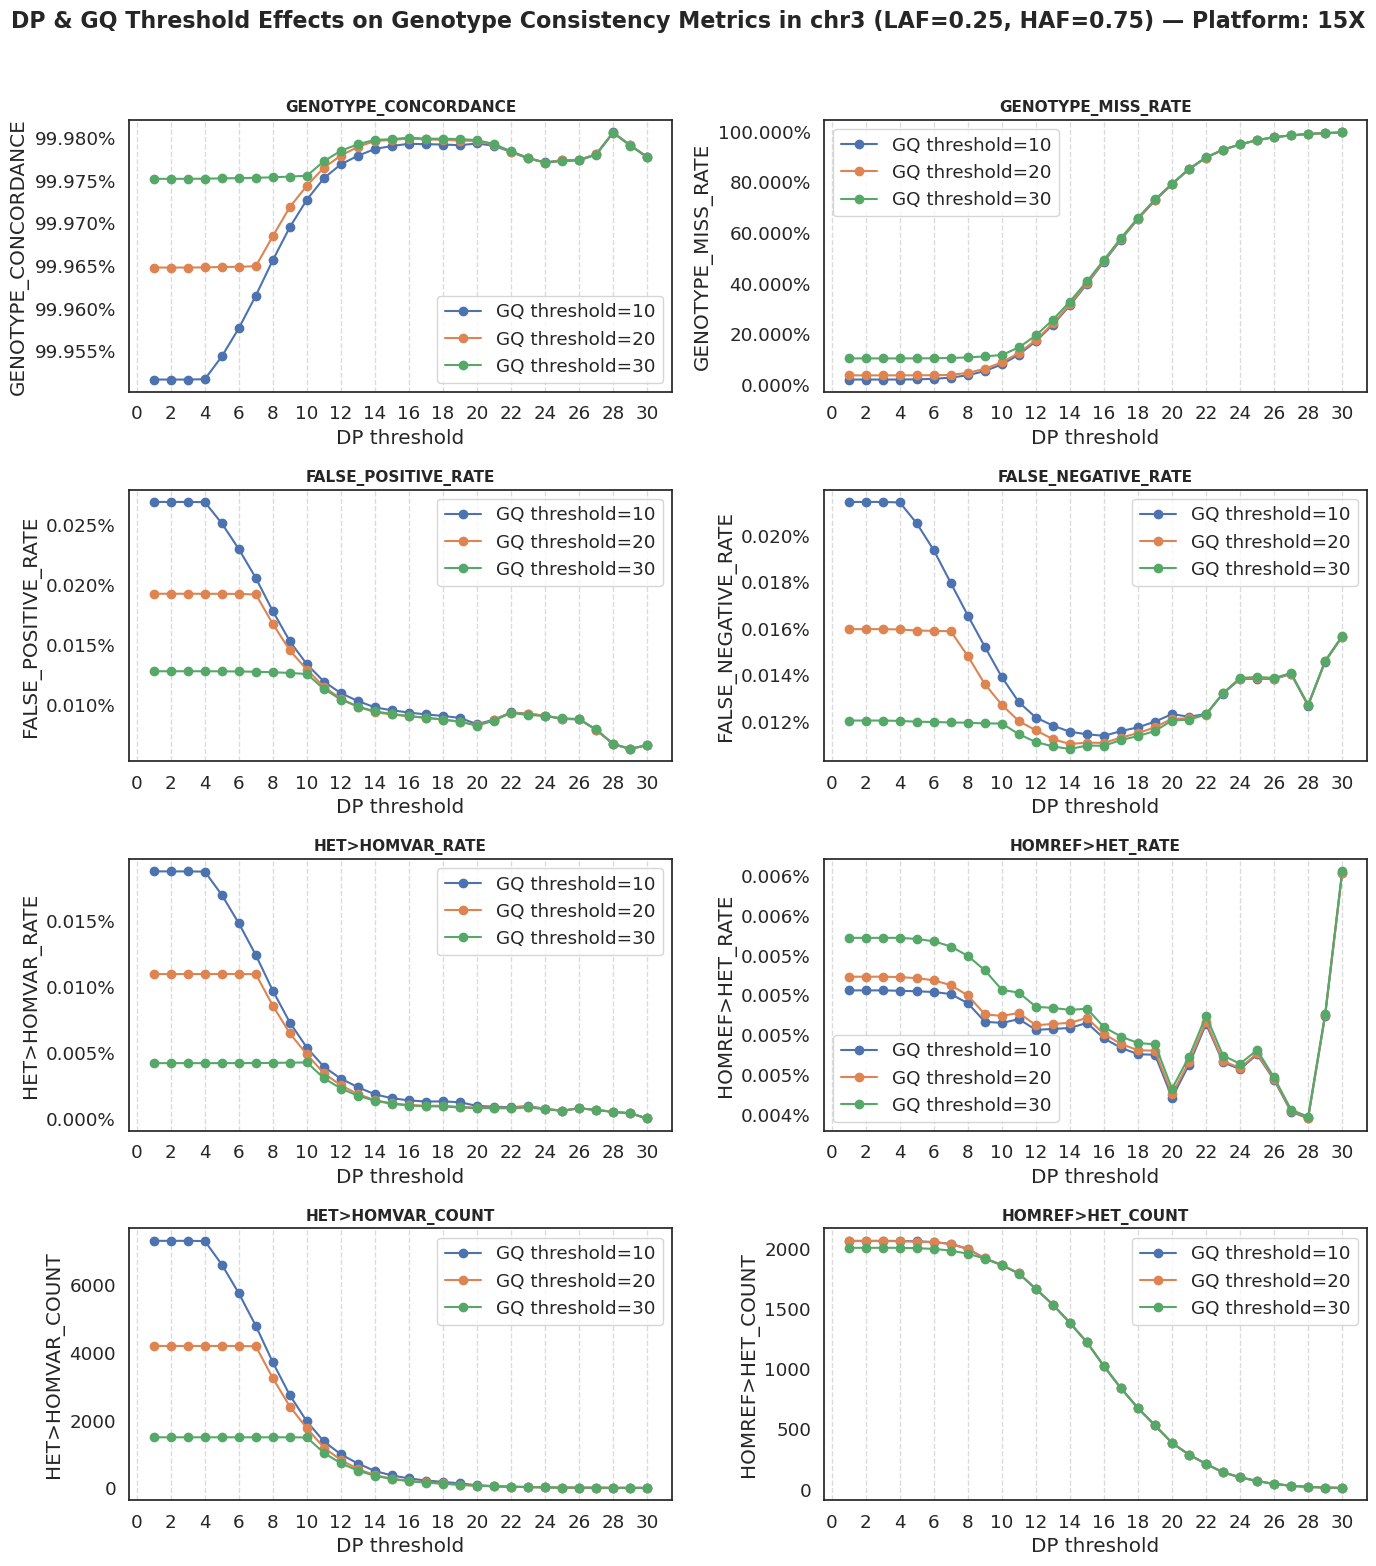

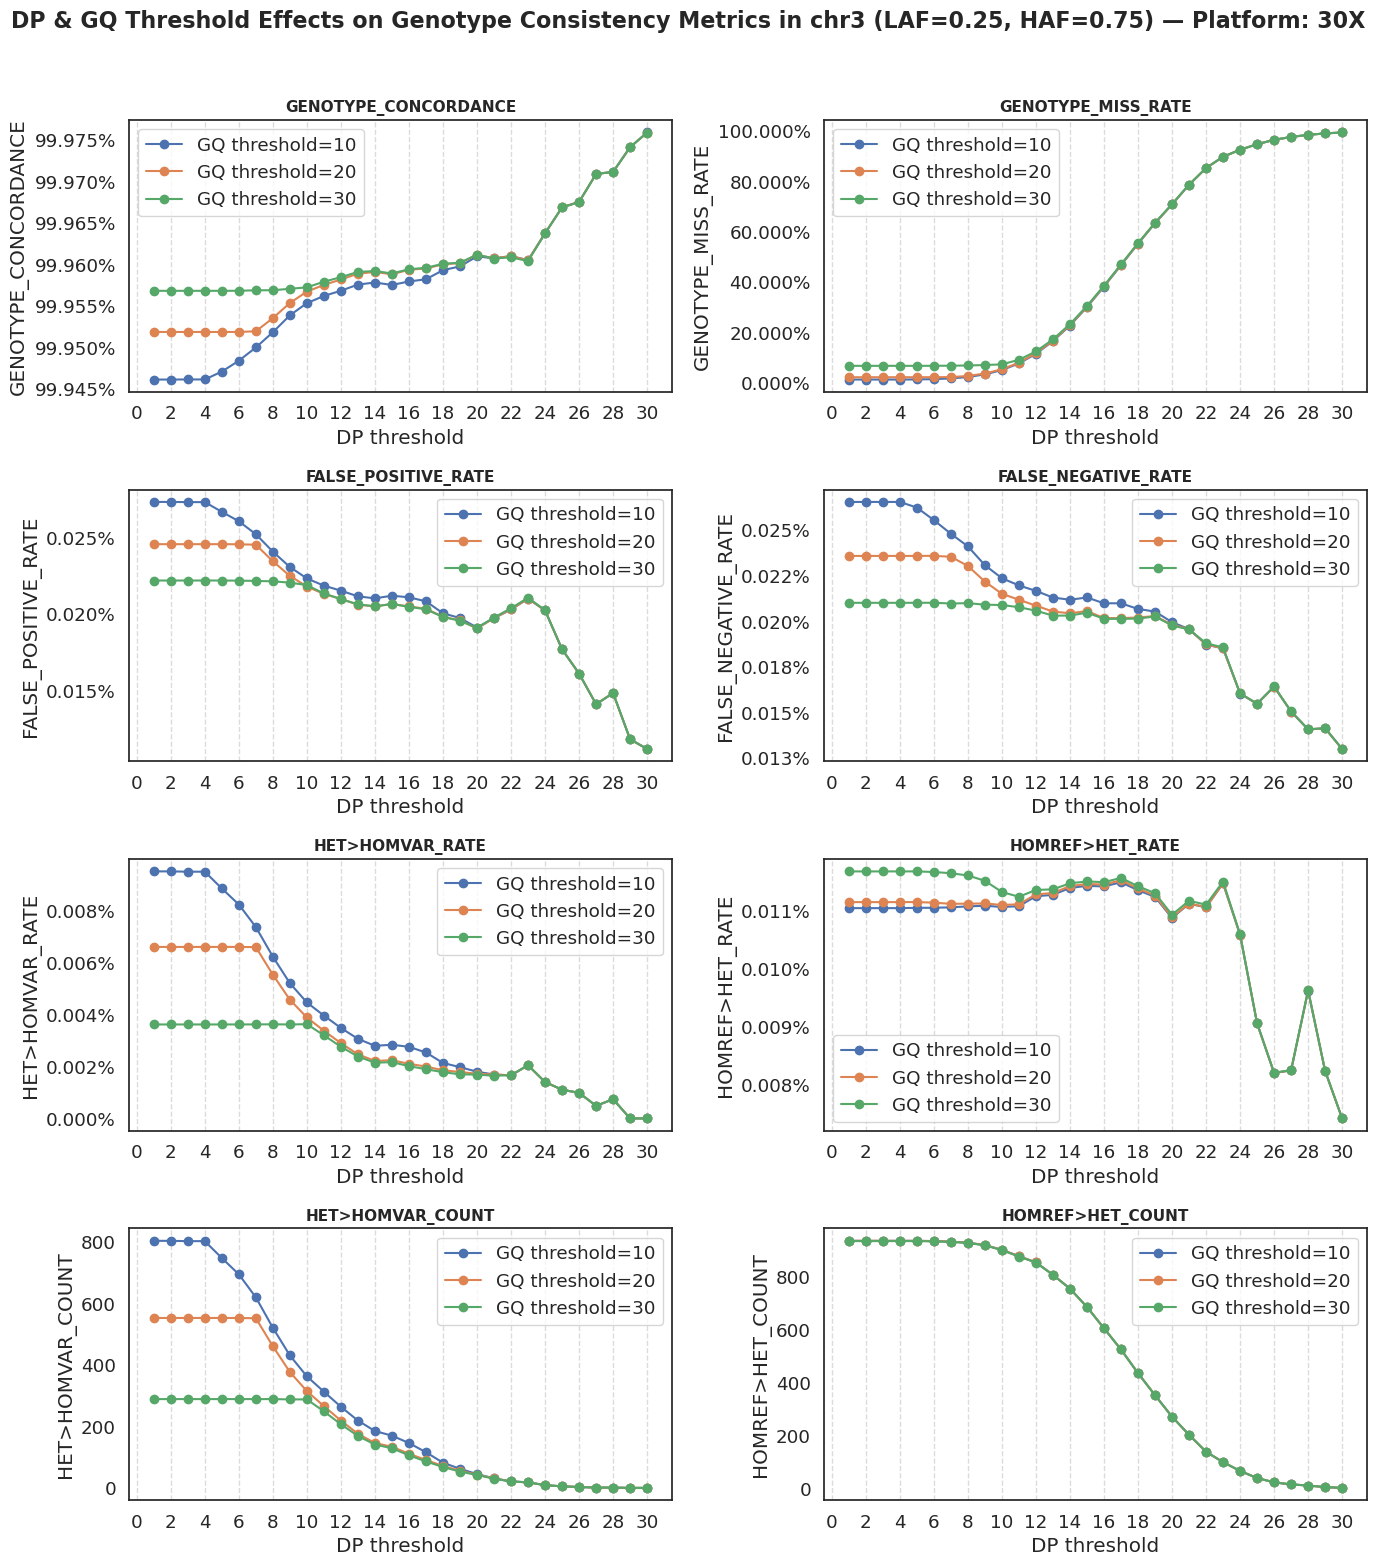

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric_vs_dp(
    summary, 
    metric="GENOTYPE_CONCORDANCE", 
    laf_val=0.25, 
    haf_val=0.75, 
    gq_values=[10, 20, 30], 
    ax=None
):
    # === 筛选指定 LAF 和 HAF 的记录 ===
    df = summary[(summary["LAF"] == laf_val) & (summary["HAF"] == haf_val)].copy()

    # === 类型转换便于排序与绘图 ===
    df["DP"] = df["DP"].astype(int)
    df["GQ"] = df["GQ"].astype(int)

    # === 使用传入 ax 或新建图（测试用） ===
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # === 遍历 GQ 分组绘图 ===
    for gq in gq_values:
        subset = df[df["GQ"] == gq].sort_values("DP")
        ax.plot(subset["DP"], subset[metric], label=f'GQ threshold={gq}', marker="o")

    # # === 自动提取平台信息 ===
    # platform_label = summary["PLATFORM"].unique()
    # if len(platform_label) == 1:
    #     platform_label = platform_label[0]
    # else:
    #     platform_label = "Multiple"

    # === 设置标题 & 标签 ===
    ax.set_title(f"{metric}", fontsize=11, fontweight='bold')
    ax.set_xlabel("DP threshold")
    ax.set_ylabel(metric)

    # === 百分比格式（只用于比例型指标） ===
    if df[metric].max() <= 1.0:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y * 100:.3f}%")) # type: ignore

    # === 坐标轴与网格设置 ===
    ax.set_xticks(np.arange(0, 31, 2))
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    ax.legend()

# === 复用的 metric 列表 ===
metrics = [
    "GENOTYPE_CONCORDANCE",
    "GENOTYPE_MISS_RATE",
    "FALSE_POSITIVE_RATE",
    "FALSE_NEGATIVE_RATE",
    "HET>HOMVAR_RATE",
    "HOMREF>HET_RATE",
    "HET>HOMVAR_COUNT", 
    "HOMREF>HET_COUNT",
]

# === 循环三个 summary 数据绘制主图 ===
for summary in [summary_all, summary_15x, summary_30x]:
    laf_val = 0.25
    haf_val = 0.75

    # === 提取平台名称 ===
    platform_label = summary["PLATFORM"].unique()
    if len(platform_label) == 1:
        platform_label = platform_label[0]
    else:
        platform_label = "Multiple"

    # === 创建主图和子图 ===
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
    axes = axes.flatten()

    for ax, metric in zip(axes, metrics):
        plot_metric_vs_dp(summary, metric=metric, laf_val=laf_val, haf_val=haf_val, ax=ax)

    # === 设置自动主标题 ===
    title = f"DP & GQ Threshold Effects on Genotype Consistency Metrics in {chr} (LAF={laf_val}, HAF={haf_val}) — Platform: {platform_label}"
    plt.suptitle(title, fontsize=16, fontweight='bold')

    # === 美化布局 ===
    plt.tight_layout(rect=(0, 0, 1, 0.965))
    plt.show()

/tmp/ipykernel_1870239/682315780.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


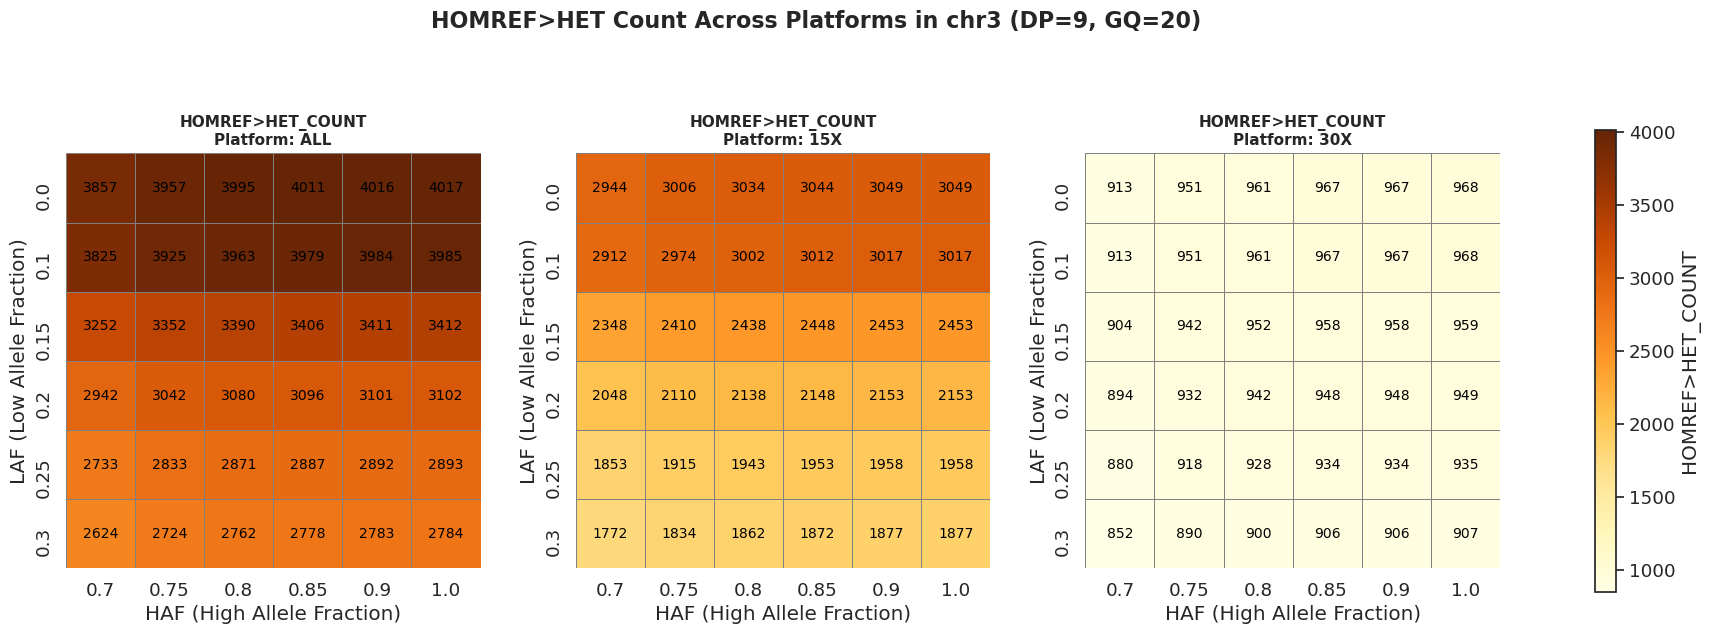

/tmp/ipykernel_1870239/682315780.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


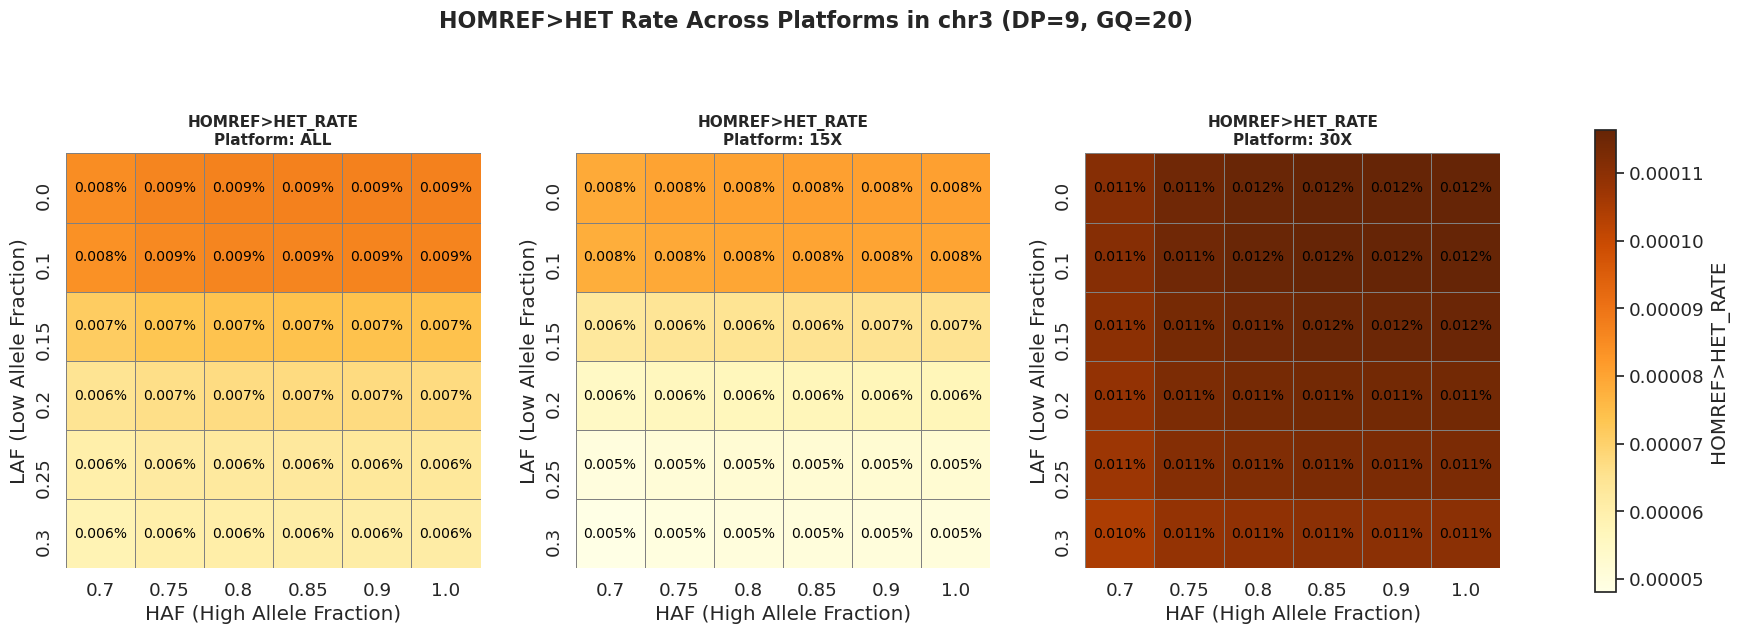

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import gridspec

# === 绘图函数：单图绘制，无colorbar ===
def plot_metric_heatmap_auto_contrast(summary, dp_thres, gq_thres, value_col="HOMREF>HET_COUNT", ax=None, vmin=None, vmax=None):
    df = summary[(summary["DP"] == dp_thres) & (summary["GQ"] == gq_thres)].copy()
    pivot = df.pivot(index="LAF", columns="HAF", values=value_col).sort_index()

    platform_label = summary["PLATFORM"].unique()[0] if summary["PLATFORM"].nunique() == 1 else "Multiple"

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    hm = sns.heatmap(
        pivot,
        ax=ax,
        cmap="YlOrBr",
        cbar=False,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor='gray'
    )

    for y in range(pivot.shape[0]):
        for x in range(pivot.shape[1]):
            val = pivot.iloc[y, x]
            if pd.notna(val):
                if np.isclose(val, int(val)):
                    label = f"{int(val)}"
                else:
                    label = f"{val * 100:.3f}%"
                ax.text(
                    x + 0.5, y + 0.5, label,
                    ha='center', va='center',
                    color='black', fontsize=10
                )

    ax.set_title(f"{value_col}\nPlatform: {platform_label}", fontsize=11, fontweight='bold')
    ax.set_xlabel("HAF (High Allele Fraction)")
    ax.set_ylabel("LAF (Low Allele Fraction)")
    ax.set_aspect("equal")  # 强制正方形格子
    
    return hm.get_children()[0]  # return heatmap image (QuadMesh) for colorbar

# === 提取共享色阶范围 ===
def get_vmin_vmax(summary_list, dp_thres, gq_thres, value_col):
    vals = []
    for summary in summary_list:
        df = summary[(summary["DP"] == dp_thres) & (summary["GQ"] == gq_thres)]
        vals.extend(df[value_col].dropna().values)
    return np.min(vals), np.max(vals)


dp_thres = 9
gq_thres = 20
summary_list = [summary_all, summary_15x, summary_30x] # type: ignore

# =============================
# COUNT 版本的热图（统一 colorbar）
# =============================


# 获取统一色阶
value_col = "HOMREF>HET_COUNT"
vmin, vmax = get_vmin_vmax(summary_list, dp_thres, gq_thres, value_col)

# 布局：3图 + 1 colorbar
fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[1, 1, 1, 0.05], wspace=0.3)

axes = [fig.add_subplot(gs[i]) for i in range(3)]
cbar_ax = fig.add_subplot(gs[3])

mappables = []
mappables.append(plot_metric_heatmap_auto_contrast(summary_all, dp_thres, gq_thres, value_col, ax=axes[0], vmin=vmin, vmax=vmax)) # type: ignore
mappables.append(plot_metric_heatmap_auto_contrast(summary_15x, dp_thres, gq_thres, value_col, ax=axes[1], vmin=vmin, vmax=vmax)) # type: ignore
mappables.append(plot_metric_heatmap_auto_contrast(summary_30x, dp_thres, gq_thres, value_col, ax=axes[2], vmin=vmin, vmax=vmax)) # type: ignore

fig.colorbar(mappables[0], cax=cbar_ax, label=value_col)
plt.tight_layout()
fig.suptitle(f"HOMREF>HET Count Across Platforms in {chr} (DP={dp_thres}, GQ={gq_thres})", fontsize=16, fontweight='bold', y=1.08)
plt.show()

# =============================
# RATE 版本的热图（统一 colorbar）
# =============================
value_col = "HOMREF>HET_RATE"
vmin, vmax = get_vmin_vmax(summary_list, dp_thres, gq_thres, value_col)

fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[1, 1, 1, 0.05], wspace=0.3)

axes = [fig.add_subplot(gs[i]) for i in range(3)]
cbar_ax = fig.add_subplot(gs[3])

mappables = []
mappables.append(plot_metric_heatmap_auto_contrast(summary_all, dp_thres, gq_thres, value_col, ax=axes[0], vmin=vmin, vmax=vmax)) # type: ignore
mappables.append(plot_metric_heatmap_auto_contrast(summary_15x, dp_thres, gq_thres, value_col, ax=axes[1], vmin=vmin, vmax=vmax)) # type: ignore
mappables.append(plot_metric_heatmap_auto_contrast(summary_30x, dp_thres, gq_thres, value_col, ax=axes[2], vmin=vmin, vmax=vmax)) # type: ignore

fig.colorbar(mappables[0], cax=cbar_ax, label=value_col)
plt.tight_layout()
fig.suptitle(f"HOMREF>HET Rate Across Platforms in {chr} (DP={dp_thres}, GQ={gq_thres})", fontsize=16, fontweight='bold', y=1.08)
plt.show()